In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [19]:
median = 5
std_deviation = 2.5
Ndata = 1000

data = np.random.normal(loc=median, scale=std_deviation, size=Ndata)

<BarContainer object of 20 artists>

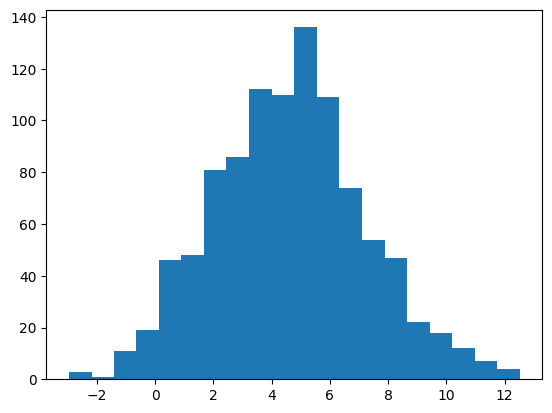

In [20]:
hist, bins_ = np.histogram(data,bins=20)
fig, ax = plt.subplots()

ax.bar(bins_[:-1], hist)